In [1]:
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")

True

In [5]:
print('DolphinDB available tables:')
sess.run('getClusterDFSTables()')

DolphinDB available tables:


array(['dfs://dailyETF/dailyETF', 'dfs://dailyOptions/dailyOptionsBasic',
       'dfs://dailyStock/dailyStockBasic',
       'dfs://dailyStock/dailyStockCapitalReduction',
       'dfs://dailyStock/dailyStockCompanies',
       'dfs://dailyStock/dailyStockDealers',
       'dfs://dailyStock/dailyStockForeign',
       'dfs://dailyStock/dailyStockForeignShare',
       'dfs://dailyStock/dailyStockMargin',
       'dfs://dailyStock/dailyStockRightDividend',
       'dfs://dailyStock/dailyStockRightDividendComp',
       'dfs://dailyStock/dailyStockShortSale',
       'dfs://dailyStock/dailyStockShortSaleBalance',
       'dfs://dailyStock/dailyStockShortSaleVolume',
       'dfs://dailyStock/dailyStockTradeDay',
       'dfs://daily_stock/dailyStock',
       'dfs://daily_stock_margin/dailyStockMargin',
       'dfs://daily_tfe/tickTFE', 'dfs://feature/indicator',
       'dfs://futTaifex/futTaifex',
       'dfs://test_indicator_tfe/testIndicator'], dtype='<U44')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [7]:
twse = pd.read_msgpack('/data/dataset/twse.msgpack')
twse.head()

/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


,open,high,low,close,order_buy,order_sell,volume
date,,,,,,,
2005-07-11,6255.40,6305.61,6249.41,6298.86,88271.0,98780.0,93877.0
2005-07-12,6337.50,6365.76,6337.50,6358.81,86565.0,111912.0,101703.0
2005-07-13,6360.60,6406.99,6352.21,6377.09,80802.0,120531.0,106134.0
2005-07-14,6403.08,6427.32,6375.75,6418.35,92496.0,114781.0,106806.0
2005-07-15,6428.44,6454.33,6410.59,6410.59,88827.0,124306.0,106727.0


## quantization
- range: 2012-12-03 to 2020-04-15 (nrow: 1,797)
- 50 / cell, floor
- day-to-maturity

In [110]:
df = twse['2012-12-01':][['close']].copy()

In [111]:
df['prc_qtz'] = df.close // 50 * 50
df['delta'] = df.prc_qtz.diff().shift(-1)

In [186]:
settlements = pd.to_datetime(pd.read_csv('settlement_txf.csv').settlement).dt.date.tolist()
df['maturity'] = df.index.where(df.index.isin(settlements)).to_series().fillna(method='bfill').values
d2m = df.groupby('maturity').size().sort_index().tolist()
df['d2m'] = sum([list(reversed(range(d))) for d in d2m], [])

df.dropna(inplace=True)
df.sort_index(ascending=True, inplace=True)

In [190]:
# vis
df[['close', 'prc_qtz', 'delta', 'd2m']].info()
df[['close', 'prc_qtz', 'delta', 'd2m']].head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2012-12-03 to 2020-04-15
Data columns (total 4 columns):
close      1797 non-null float64
prc_qtz    1797 non-null float64
delta      1797 non-null float64
d2m        1797 non-null int64
dtypes: float64(3), int64(1)
memory usage: 70.2 KB


,close,prc_qtz,delta,d2m
date,,,,
2012-12-03,7599.91,7550.0,50.0,12
2012-12-04,7600.98,7600.0,0.0,11
2012-12-05,7649.05,7600.0,0.0,10
2012-12-06,7623.26,7600.0,0.0,9
2012-12-07,7642.26,7600.0,0.0,8
2012-12-10,7609.50,7600.0,0.0,7
2012-12-11,7613.69,7600.0,50.0,6
2012-12-12,7690.19,7650.0,100.0,5
2012-12-13,7757.09,7750.0,-100.0,4


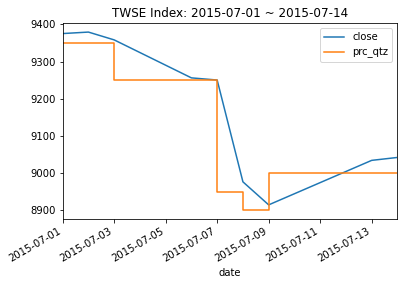

In [191]:
# vis
d_start, d_end = '2015-07-01', '2015-07-14' 
df_plot = df[d_start: d_end]
ax = df_plot[['close']].plot(title=f'TWSE Index: {d_start} ~ {d_end}')
df_plot[['prc_qtz']].plot(drawstyle='steps', ax=ax)

In [193]:
df.groupby('d2m').size().to_frame('exists')

,exists
d2m,
0,89
1,89
2,89
3,89
4,89
5,89
6,89
7,89
8,89


## check feasible shape of transition matrix

Text(0.5, 1.0, '#(cells)')

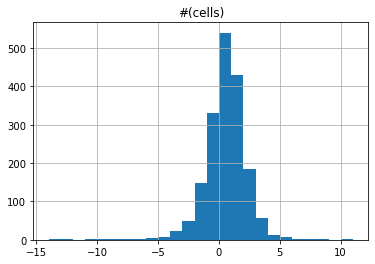

In [20]:
ax = df.delta.div(50).hist(bins=25)
ax.set_title('#(cells)')

In [21]:
df.delta.div(50).quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]).to_frame('delta').T

,0.00,0.10,0.25,0.50,0.75,0.90,1.00
delta,-14.0,-2.0,-1.0,0.0,1.0,2.0,11.0


# compute probabilty, conditional on day-to-maturity